FloatSlider(value=1.0, description='a', max=10.0)

IntSlider(value=-1, description='Closed value', max=10, min=-10)

FloatSlider(value=6.0, description='Closed avg time')

IntSlider(value=1, description='Opened value', max=10, min=-10)

FloatSlider(value=2.0, description='Opened avg time')

FloatSlider(value=2.0, description='D', min=0.1)

SelectionSlider(description='Delta t', index=1, options=(0.1, 0.01, 0.001, 0.0001), value=0.01)

IntSlider(value=50000, description='Records', max=100000, min=1000, step=1000)

Dropdown(description='Model Force', options={'Square Force': <function model_force_square at 0xffd9dfe7a2a0>, …

VBox()

Dropdown(description='Random Force', options={'Gauss Force': <function random_force_gauss at 0xffda38bc8220>, …

Button(description='Run Model', style=ButtonStyle())

<Figure size 640x480 with 0 Axes>

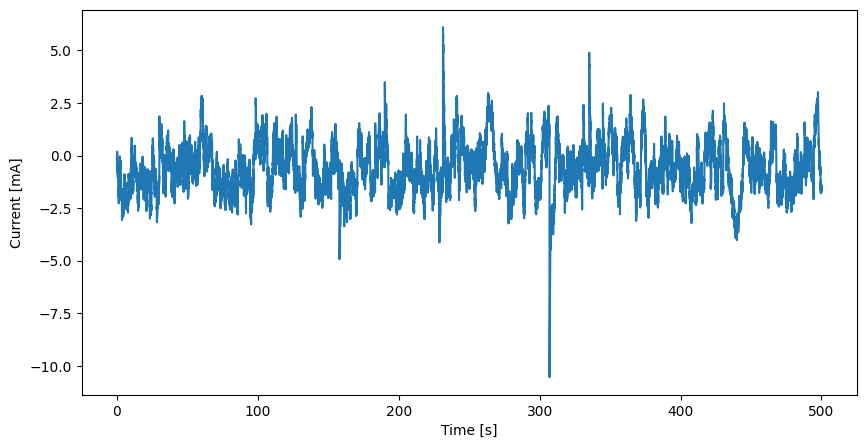

a: 1.0, closed_0: -1, closed_1: 6.0, opened_0: 1, opened_1: 2.0, D: 2.0, delta_t: 0.01, records: 50000, model_force: Square Force, random_force: Levy Force, force_params: alpha: 1.85, beta_closed: 1.0, beta_opened: -1.0, location: 0, scale: 0.5


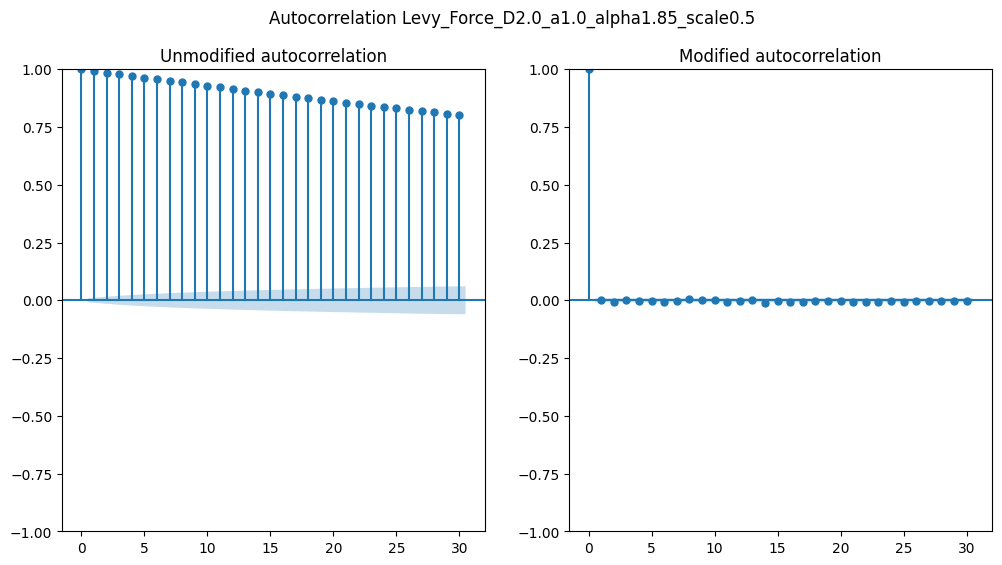

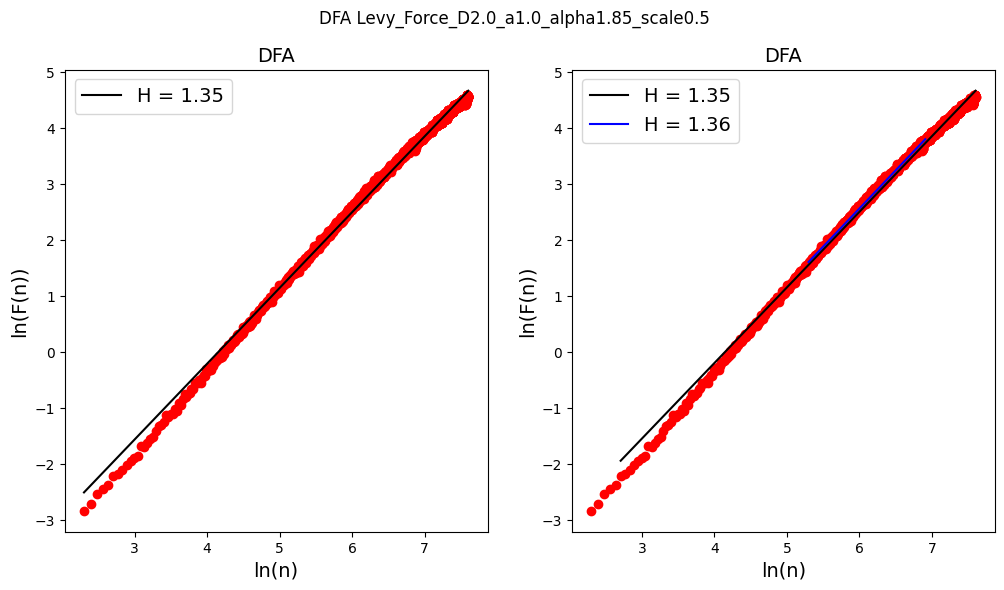

In [1]:
import monostable_model
from monostable_model import ion_channel_model, model_force_square, random_force_gauss, random_force_levy
from ipywidgets import FloatSlider, IntSlider, Dropdown, SelectionSlider, VBox, Button
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

def ion_channel_interactive(a, closed_0, closed_1, opened_0, opened_1, D, delta_t, records, model_force, random_force, **force_params):
    """
    Generates an interactive widget for the ion channel model.
    """
    closed = (closed_0, closed_1)
    opened = (opened_0, opened_1)
    return ion_channel_model(a, closed, opened, D, delta_t, records, model_force, random_force, **force_params)


a_slider = FloatSlider(min=0.0, max=10.0, step=0.1, value=1, description='a')
closed_0_slider = IntSlider(min=-10, max=10, step=1, value=-1, description='Closed value')
closed_1_slider = FloatSlider(min=0.0, max=100.0, step=0.1, value=6.0, description='Closed avg time')
opened_0_slider = IntSlider(min=-10, max=10, step=1, value=1, description='Opened value')
opened_1_slider = FloatSlider(min=0.0, max=100.0, step=0.1, value=2.0, description='Opened avg time')
D_slider = FloatSlider(min=0.1, max=100.0, step=0.1, value=2.0, description='D')
delta_t_slider = SelectionSlider(
    options=[10**-i for i in range(1, 5)],
    value=0.01,
    description='Delta t',
)
records_slider = IntSlider(min=1000, max=100000, step=1000, value=50000, description='Records')

model_force_dropdown=Dropdown(
        options={'Square Force': model_force_square, 'Other Force': lambda x: x**2},
        value=model_force_square,
        description='Model Force',
)

random_force_dropdown = Dropdown(
    options={'Gauss Force': random_force_gauss, 'Levy Force': random_force_levy},
    value=random_force_gauss,
    description='Random Force',
)

force_params_box = VBox()

def update_force_params(*args):
    """
    Updates the force_params_box based on the selected random force.
    """
    force_type = random_force_dropdown.value
    if force_type == random_force_levy:
        # Define widgets specific to 'Other Force'
        alpha = FloatSlider(min=0, max=2, step=0.01, value=1.85, description='alpha')
        beta_opened = FloatSlider(min=-1.0, max=0.0, step=0.01, value=-1.0, description='beta_opened')
        beta_closed = FloatSlider(min=0.0, max=1, step=0.01, value=1.0, description='beta_closed')
        loc = IntSlider(min=0, max=100, step=1, value=0, description='location')
        scale = FloatSlider(min=0, max=100, step=0.1, value=0.5, description='scale')
        force_params_box.children = [alpha, beta_closed, beta_opened, loc, scale]
    else:
        force_params_box.children = []

random_force_dropdown.observe(update_force_params, names='value')

display(
    a_slider,
    closed_0_slider,
    closed_1_slider,
    opened_0_slider,
    opened_1_slider,
    D_slider,
    delta_t_slider,
    records_slider,
    model_force_dropdown,
    force_params_box,
    random_force_dropdown
)

def on_button_click(b):
    """
    Callback for the 'Run Model' button.
    """
    force_params = {child.description: child.value for child in force_params_box.children}
    data = ion_channel_interactive(
        a_slider.value,
        closed_0_slider.value,
        closed_1_slider.value,
        opened_0_slider.value,
        opened_1_slider.value,
        D_slider.value,
        delta_t_slider.value,
        records_slider.value,
        model_force_dropdown.value,
        random_force_dropdown.value,
        **force_params
    )
    data, breakpoints = data[0].T, data[1]
    plt.clf()  
    plt.figure(figsize=(10, 5))
    plt.plot(data[0], data[1])
    plt.xlabel("Time [s]")
    plt.ylabel("Current [mA]")
    # for bp in breakpoints:
    #     plt.axvline(x=bp, color='r', linestyle='--')
    params_str = (
        f"a: {a_slider.value}, "
        f"closed_0: {closed_0_slider.value}, "
        f"closed_1: {closed_1_slider.value}, "
        f"opened_0: {opened_0_slider.value}, "
        f"opened_1: {opened_1_slider.value}, "
        f"D: {D_slider.value}, "
        f"delta_t: {delta_t_slider.value}, "
        f"records: {records_slider.value}, "
        f"model_force: {model_force_dropdown.label}, "
        f"random_force: {random_force_dropdown.label}, "
        f"force_params: {', '.join([f'{key}: {value}' for key, value in force_params.items()])}"
    )
    plt.show()
    print(params_str)
    # TODO temporary naming scheme for simplicity
    name = f"{random_force_dropdown.label.replace(' ', '_')}_D{D_slider.value}_a{a_slider.value}_alpha{force_params['alpha']}_scale{force_params['scale']}"
    monostable_model.calculate_autocorelation_acf(data[1], title=name)
    monostable_model.calculate_autocorelation_dfa(data[1], title=name)
    # plt.hist(np.diff(breakpoints), bins=50)
    # plt.show()

run_button = Button(description="Run Model")
run_button.on_click(on_button_click)
display(run_button)

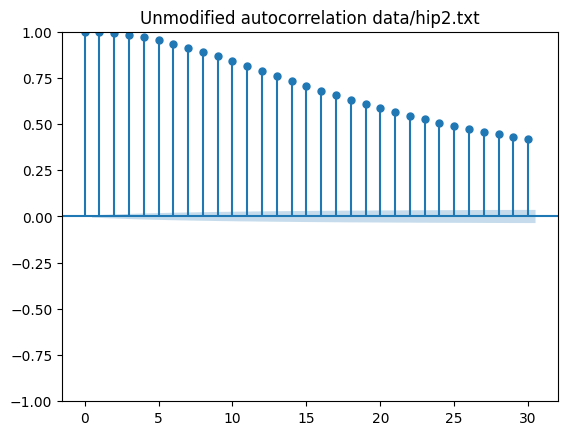

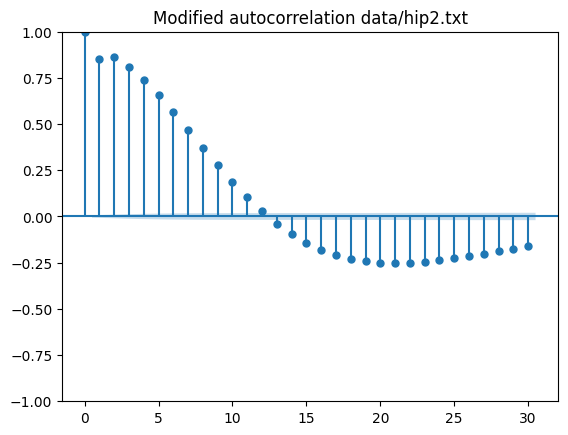

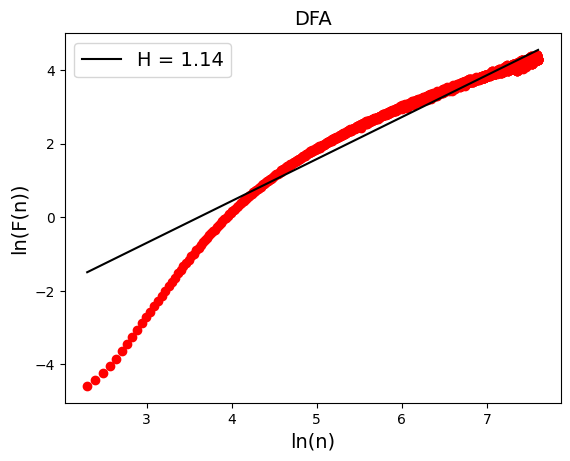

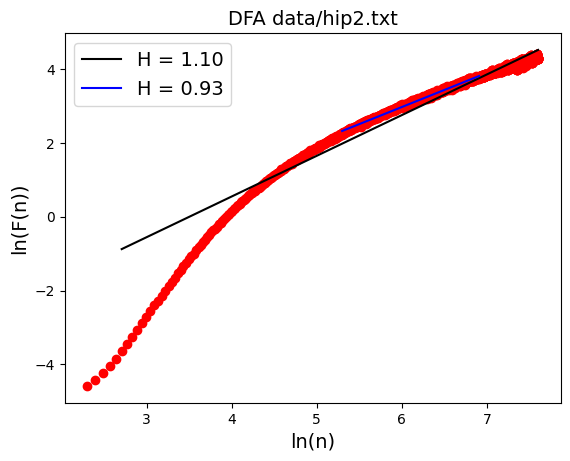

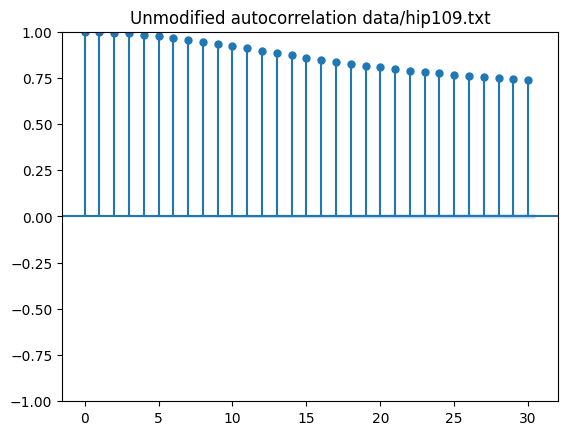

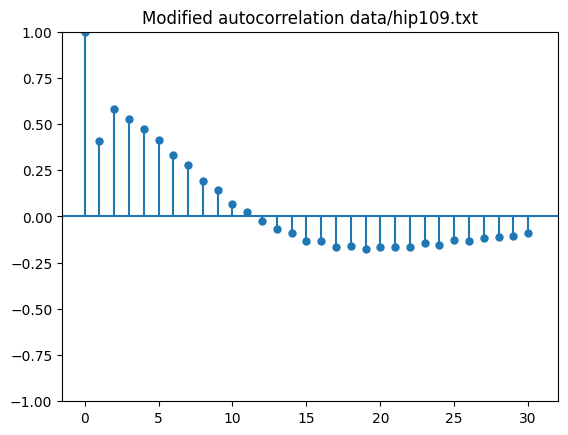

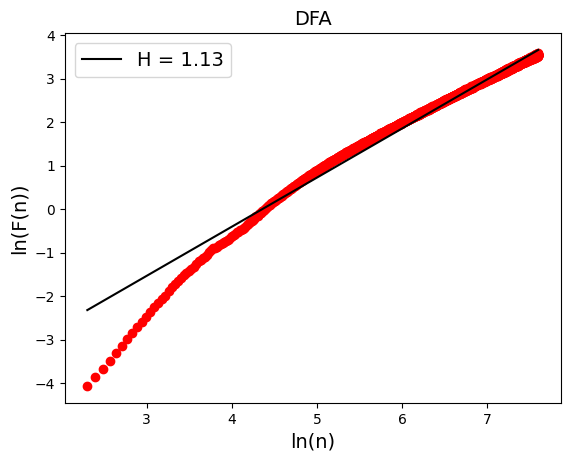

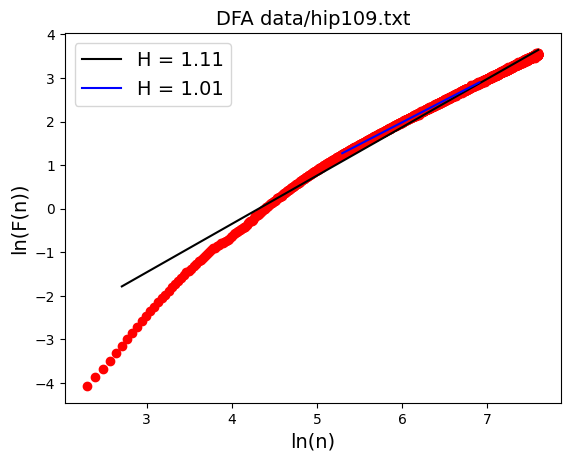

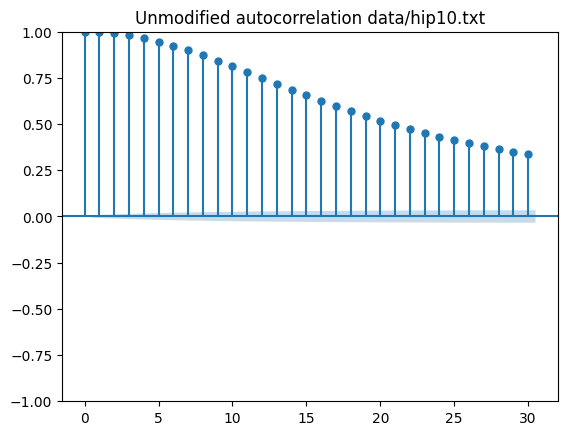

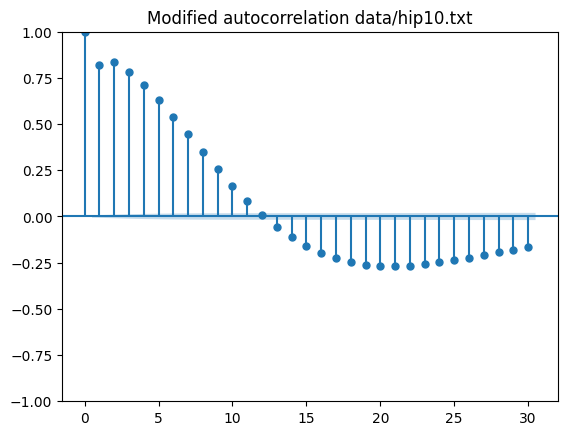

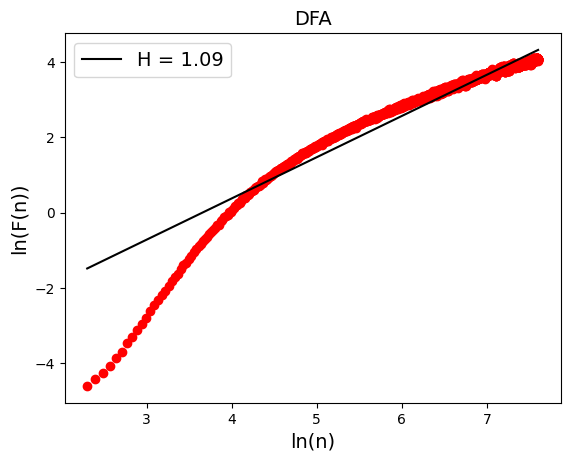

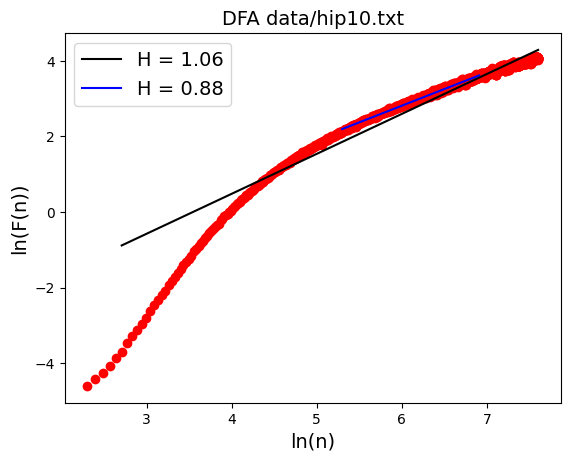

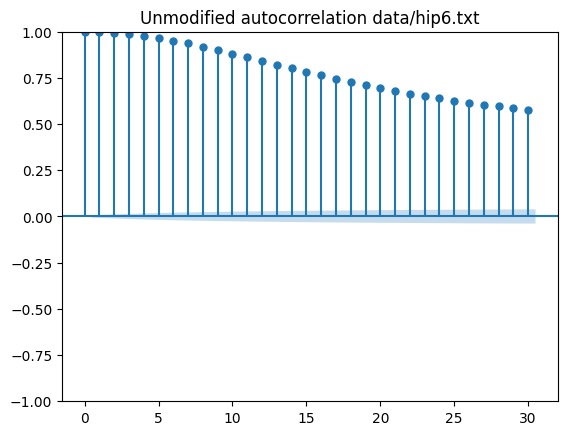

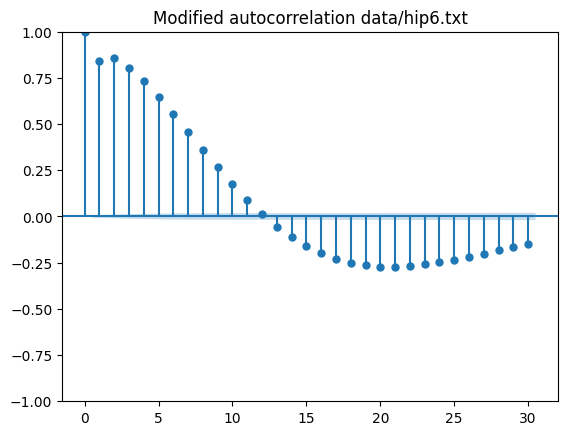

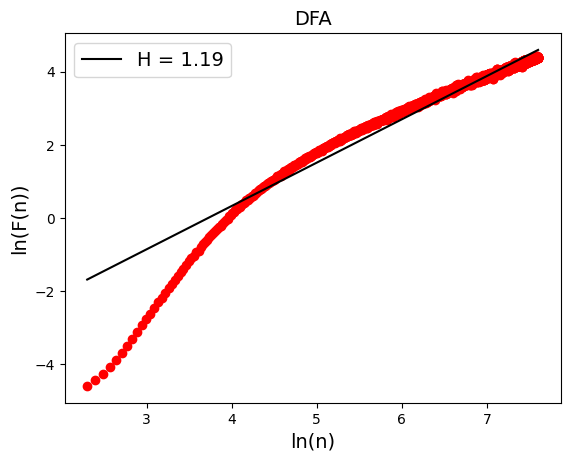

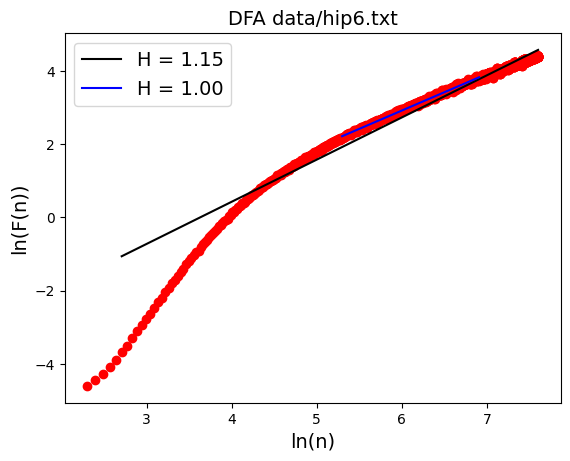

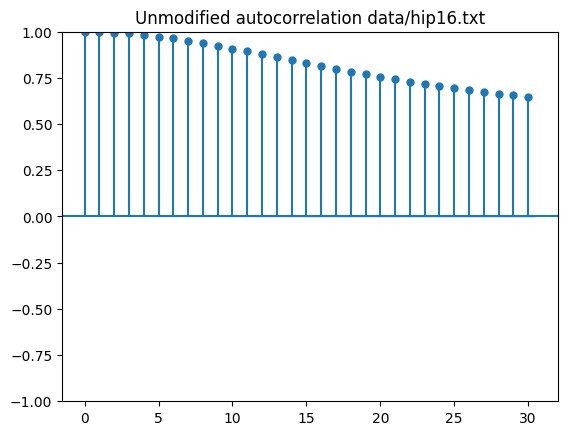

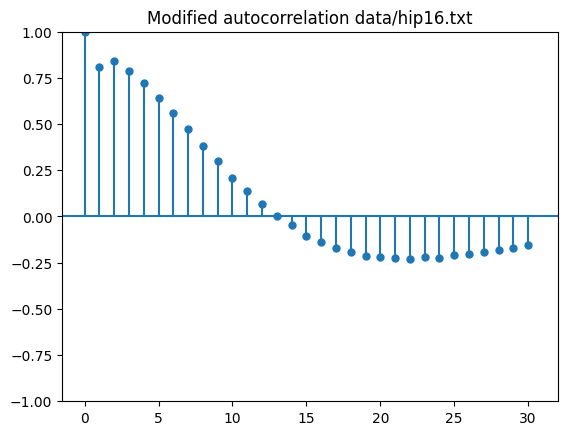

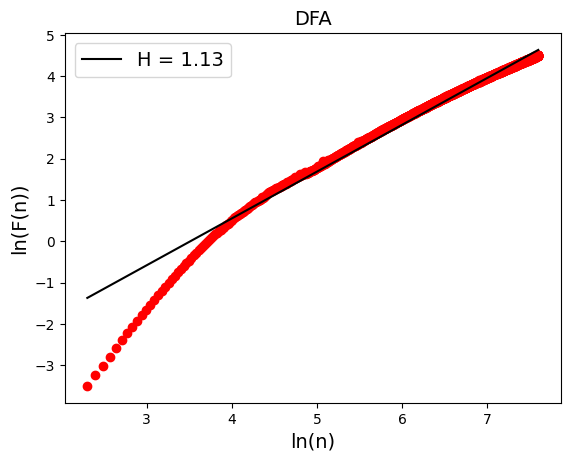

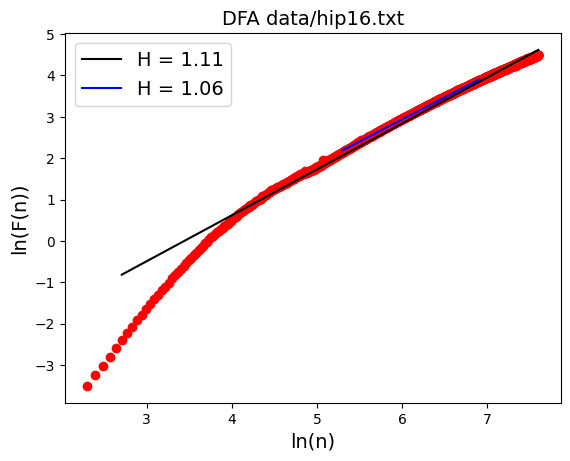

In [1]:
import os
import glob
import matplotlib.pyplot as plt
from monostable_model import calculate_autocorelation_dfa, calculate_autocorelation_acf
import numpy as np

# Find all hip files in the data directory
file_pattern = os.path.join("data", "hip*.txt")
files = glob.glob(file_pattern)
batch_size = 1
# Process each file
for file_path in files:
    cnt = 0
    sum = 0
    file_data = []
    
    with open(file_path) as data_file:
        for record in data_file:
            if cnt < batch_size:
                record = record.strip()
                sum += float(record)
                cnt += 1
            else:
                cnt = 0
                file_data.append(sum / batch_size)
                sum = 0
    
    # Calculate autocorrelation
    calculate_autocorelation_acf(file_data, title=file_path)
    calculate_autocorelation_dfa(file_data, title=file_path)